# Two Players Zero-Sum Game

Many example of non-cooperative behavior between two adversarial agents can be modelled through zero-sum games [1]. Let us consider vectors $\mathbf{x}_i \in \Delta_i$ as the decision variable of the $i$-th player, with $i \in \{1,2\}$, where $\Delta_i \subset \mathbb{R}^{n_i}$ is the simplex constraints set defined as $\Delta_i := \{\mathbf{x} \in \mathbb{R}^{n_i} : \mathbf{1}^\top \mathbf{x} = 1\}$, for all $i \in \{1,2\}$. Let $\mathbf{x} := \text{col}(\mathbf{x}_i)_{i = 1}^2$. The set of the combined decisions, for the two agents, is thus $\mathcal{S} = \Delta_1 \times \Delta_2$. Let's create it.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from monviso import VI

np.random.seed(2024)

n1, n2 = 50, 50

# Simplex constraints' set
y = cp.Variable(n1 + n2)
S = [cp.sum(y[:n1]) == 1, cp.sum(y[n1:]) == 1]

The players try to solve the following problem

$$
\begin{equation}
    \min_{\mathbf{x}_1 \in \Delta_1} \max_{\mathbf{x}_2 \in \Delta_2} \Phi(\mathbf{x}_1, \mathbf{x}_2)
\end{equation}
$$

whose (Nash) equilibrium solution is achieved for $\mathbf{x}^*$ satisfying the following

$$
\begin{equation}
    \label{eq:saddle}
    \Phi(\mathbf{x}^*_1, \mathbf{x}_2) \leq \Phi(\mathbf{x}^*_1, \mathbf{x}^*_2) \leq \Phi(\mathbf{x}_1, \mathbf{x}^*_2), \quad \forall \mathbf{x} \in \Delta_1 \times \Delta_2
\end{equation}
$$

For the sake of simplicity, we consider $\Phi(\mathbf{x}_1, \mathbf{x}_2) := \mathbf{x}^\top_1 \mathbf{H} \mathbf{x}_2$, for some $\mathbf{H} \in \mathbb{R}^{n_1 \times n_2}$. Doing so, the equilibrium condition in the previous equation can be written as a VI, with the mapping $\mathbf{F} : \mathbb{R}^{n_1 + n_2} \to \mathbb{R}^{n_1 + n_2}$ defined as

$$
\begin{equation}
    \mathbf{F}(\mathbf{x}) = \begin{bmatrix} \mathbf{H} \mathbf{x}_2 \\ -\mathbf{H}^\top \mathbf{x}_1 \end{bmatrix} = \underbrace{\begin{bmatrix} & \mathbf{H} \\ -\mathbf{H}^\top & \end{bmatrix} \mathbf{x}}_{=:\mathbf{G}}
\end{equation}
$$

Let's start from creating $\mathbf{G}$ and the vector mapping $\mathbf{F}(\cdot)$:

In [2]:
H = np.random.rand(n1, n2)
G = np.block([
    [np.zeros((n1, n2)), H], 
    [-H.T, np.zeros((n1, n2))]
])

F = lambda x: G @ x

$\mathbf{F}(\cdot)$ is Lipschitz, being linear, with constant $L = \|\mathbf{G}\|_2$.

In [3]:
L = np.linalg.norm(G, 2)

Let's create the VI associated with the game and an initial solution

In [4]:
tpzsg = VI(F, y=y, S=S)
x = np.random.rand(n1 + n2)

In this case, $\mathbf{F}(\cdot)$ is merely monotone, so we don't have guarantees for proximal gradient to converge (although it might still be used). However, there are a lot of alternative algorithms for merely monotone VIs. Let's compare three of them: extragradient ([`eg`](../../api/#extragradient)), Forward-backward-forward ([`fbf`](../../api/#forward-backward-forward)), and Popov's method ([`popov`](../../api/#popovs-method)).

In [5]:
max_iter = 1000

residuals_eg = np.zeros(max_iter)
residuals_fbf = np.zeros(max_iter)
residuals_popov = np.zeros(max_iter)

# Copy the same initial solution for the three methods
xk_eg = np.copy(x)
xk_fbf = np.copy(x)

xk_popov = np.copy(x)
yk_popov = np.copy(xk_popov)

for k in range(max_iter):
    # Extragradient
    xk1_eg = tpzsg.eg(xk_eg, 1 / L)
    residuals_eg[k] = np.linalg.norm(xk_eg - xk1_eg)
    xk_eg = xk1_eg
    
    # Forward-backward-forward
    xk1_fbf = tpzsg.fbf(xk_fbf, 1 / L)
    residuals_fbf[k] = np.linalg.norm(xk_fbf - xk1_fbf)
    xk_fbf = xk1_fbf

    # Popov's method
    xk1_popov, yk1_popov = tpzsg.popov(xk_popov, yk_popov, 1 / (2*L))
    residuals_popov[k] = np.linalg.norm(xk_popov - xk1_popov)
    xk_popov = xk1_popov
    yk_popov = yk1_popov

The API docs have some detail on the [convention for naming iterative steps](../../api/#iterative-methods). Let's check out the residuals for each method. 

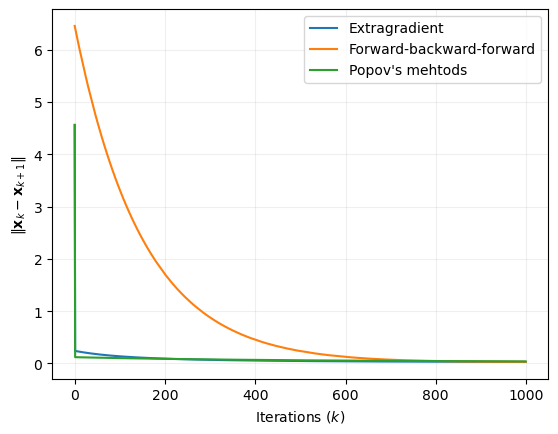

In [6]:
fig, ax = plt.subplots()

ax.plot(residuals_eg, label="Extragradient")
ax.plot(residuals_fbf, label="Forward-backward-forward")
ax.plot(residuals_popov, label="Popov's method")

ax.grid(True, alpha=0.2)
ax.set_xlabel("Iterations ($k$)")
ax.set_ylabel(r"$\|\mathbf{x}_k - \mathbf{x}_{k+1}\|$")
plt.legend()
plt.show()

## References
[1] Lemke, C. E., & Howson, Jr, J. T. (1964). Equilibrium points of bimatrix games. Journal of the Society for industrial and Applied Mathematics, 12(2), 413-423.